## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import shap

## Data Preparation

In [2]:
df = pd.read_csv('data/Bank Customer Churn Prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
X = df.drop(columns=['churn', 'customer_id'])
y = df['churn']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111, shuffle=True, stratify=y)

In [5]:
enc = OneHotEncoder(handle_unknown='ignore')
X_train_oh = enc.fit_transform(X_train[['country', 'gender']])
X_test_oh = enc.transform(X_test[['country', 'gender']])

column_name = enc.get_feature_names_out(['country', 'gender'])
X_train_oh = pd.DataFrame(X_train_oh.toarray(), columns=column_name, index=X_train.index)
X_test_oh = pd.DataFrame(X_test_oh.toarray(), columns=column_name, index=X_test.index)

X_train_num =  pd.concat([X_train.drop(columns=['country', 'gender']), X_train_oh], axis=1)
X_test_num =  pd.concat([X_test.drop(columns=['country', 'gender']), X_test_oh], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [6]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train_num, y_train, test_size=0.33, random_state=111, shuffle=True, stratify=y_train)

## Train

In [7]:
params = {
    'objective': 'binary:logistic',  # Binary classification
    'max_depth': 5,                  # Maximum depth of a tree
    'eta': 0.1,                      # Learning rate
    'subsample': 0.9,                # Subsample ratio of the training instances
    'colsample_bytree': 0.9,         # Subsample ratio of columns when constructing each tree
    'eval_metric': 'auc',            # Evaluation metric
    'scale_pos_weight': 2, 
    'tree_method': 'hist',
    'alpha': 0.1, 
    'gamma': 0.1, 
}

xgb_train = xgb.XGBClassifier(**params)
xgb_train.fit(X_train_2, y_train_2, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=10)

dump_list = xgb_train.get_booster().get_dump()
num_trees = len(dump_list)

clf_xgb = xgb.XGBClassifier(**params, n_estimators=num_trees)
clf_xgb.fit(X_train_num, y_train)

y_pred_dt = clf_xgb.predict(X_test_num)

[0]	validation_0-auc:0.84354
[10]	validation_0-auc:0.87359
[20]	validation_0-auc:0.87494
[30]	validation_0-auc:0.87367
[40]	validation_0-auc:0.87358
[41]	validation_0-auc:0.87313


/home/marek/anaconda3/envs/tibia/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [8]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2628
           1       0.63      0.59      0.61       672

    accuracy                           0.84      3300
   macro avg       0.76      0.75      0.76      3300
weighted avg       0.84      0.84      0.84      3300



In [9]:
confusion_matrix(y_test, y_pred_dt)

array([[2391,  237],
       [ 275,  397]])

## SHAP explainer

In [10]:
explainer = shap.TreeExplainer(clf_xgb)

In [11]:
shap_values = explainer.shap_values(X_test_num)

### summary plot

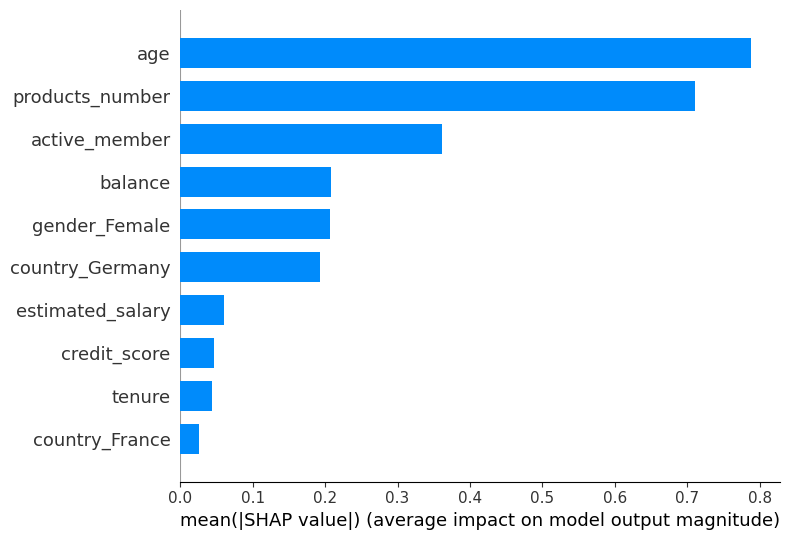

In [12]:
shap.summary_plot(shap_values, features=X_test_num, feature_names=X_test_num.columns, plot_type="bar", max_display=10)

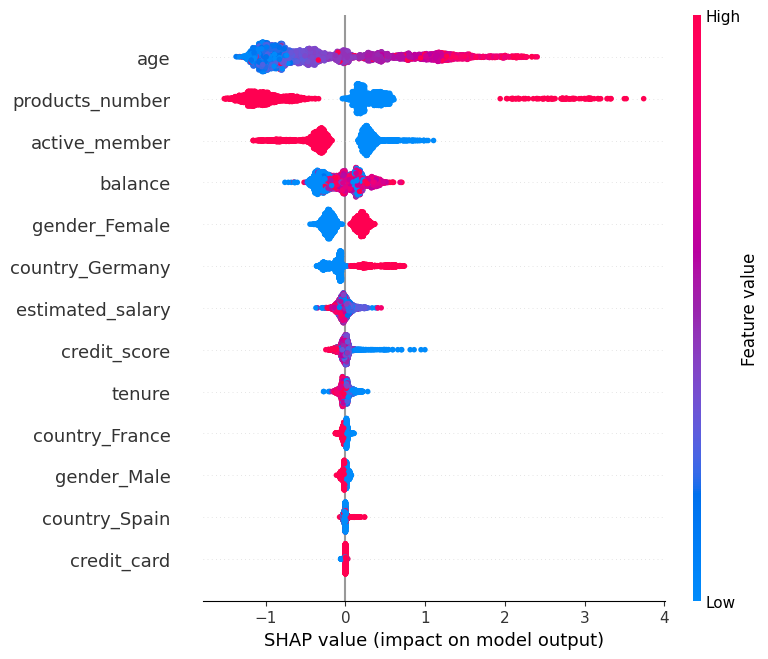

In [13]:
shap.summary_plot(shap_values, X_test_num)

### dependence plot

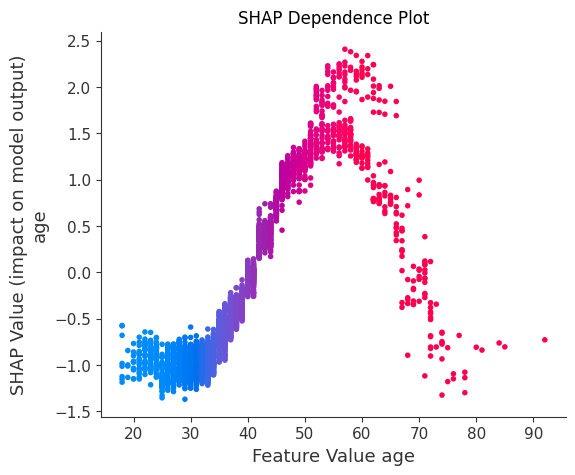

In [14]:
# Visualize dependence plot for a specific feature
feature_name = 'age'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='age', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()


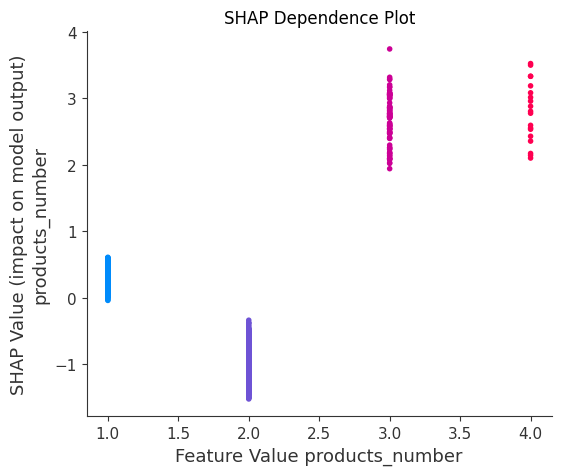

In [32]:
# Visualize dependence plot for a specific feature
feature_name = 'products_number'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='products_number', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()


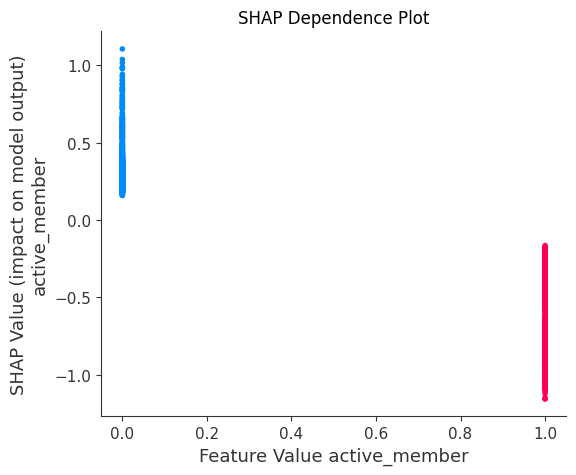

In [37]:
# Visualize dependence plot for a specific feature
feature_name = 'active_member'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='active_member', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()


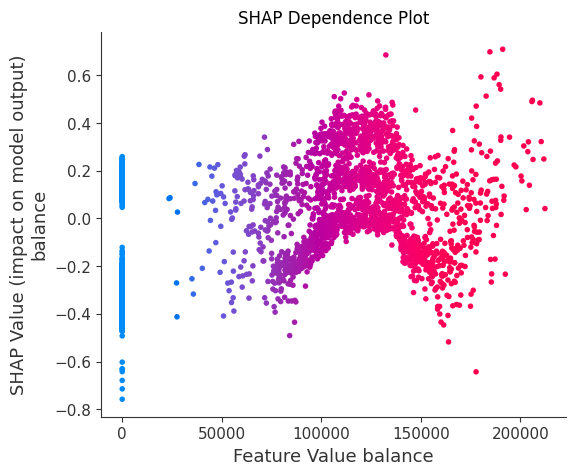

In [31]:
# Visualize dependence plot for a specific feature
feature_name = 'balance'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='balance', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()


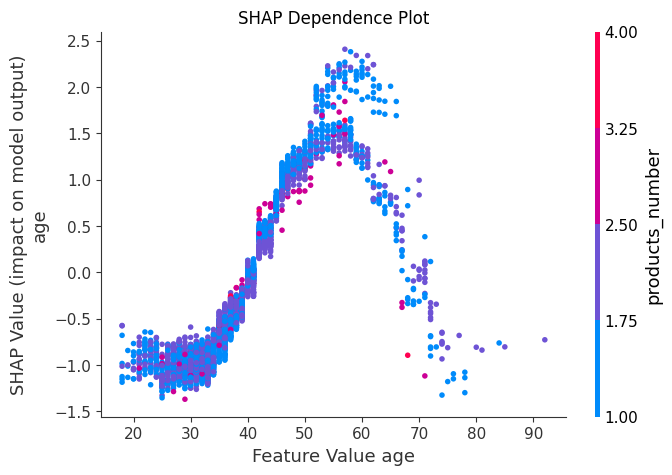

In [33]:
# Visualize dependence plot for a specific feature
feature_name = 'age'  # Specify the feature you want to analyze
shap.dependence_plot(feature_name, shap_values, X_test_num, interaction_index='products_number', show=False)
plt.title("SHAP Dependence Plot")
plt.xlabel(f"Feature Value {feature_name}")
plt.ylabel(f"SHAP Value (impact on model output)\n{feature_name}")
plt.show()
# print("The SHAP dependence plot shows the relationship between the value of a specific feature and the model output. It helps understand how changes in the feature affect the model's predictions.")

### interaction values

In [34]:
shap_interaction_values = explainer.shap_interaction_values(X_test_num)

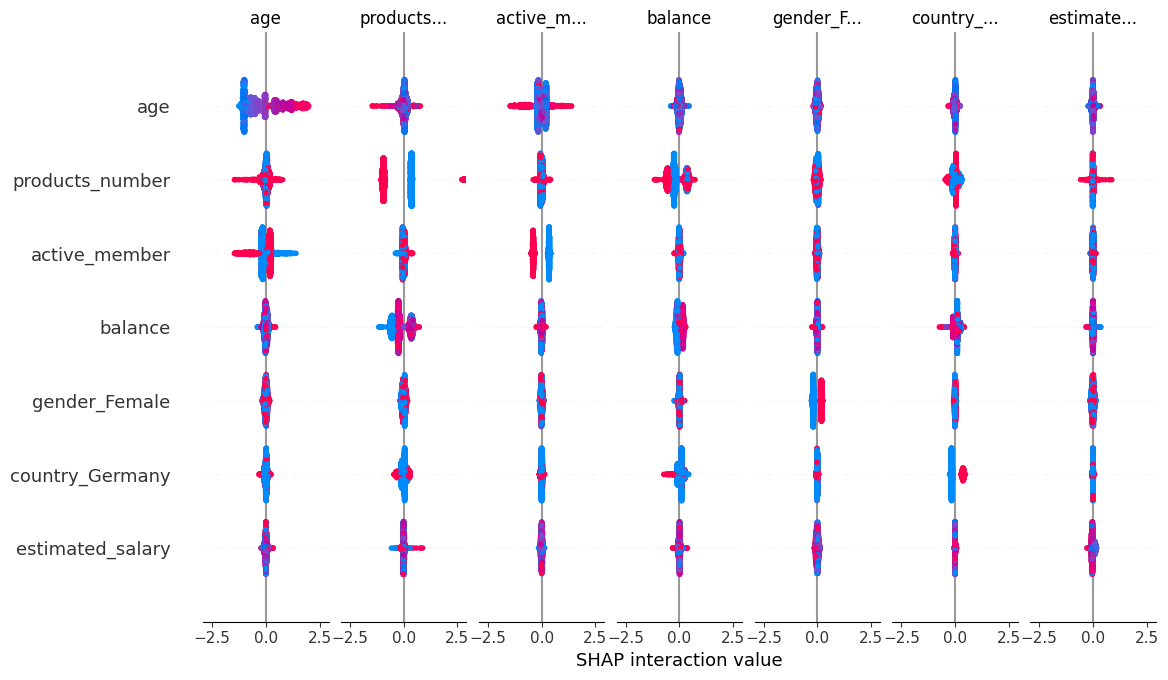

In [35]:
shap.summary_plot(shap_interaction_values, X_test_num)

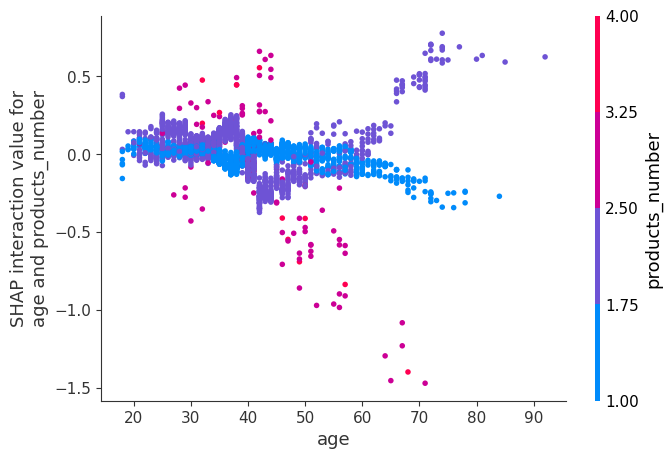

In [39]:
shap.dependence_plot(
    ("age", "products_number"),
    shap_interaction_values, X_test_num,
    display_features=X_test_num
)

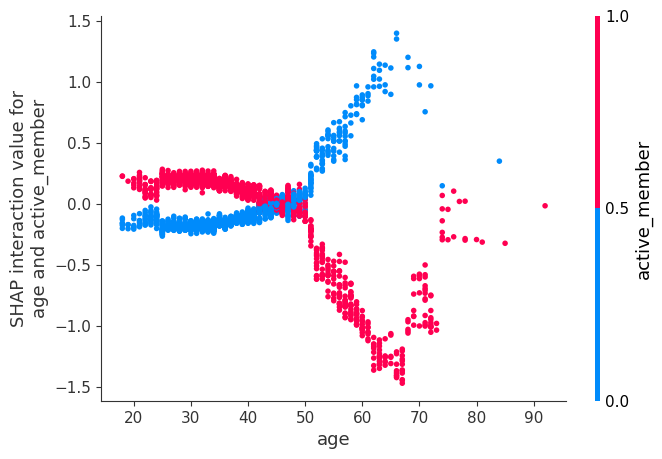

In [40]:
shap.dependence_plot(
    ("age", "active_member"),
    shap_interaction_values, X_test_num,
    display_features=X_test_num
)

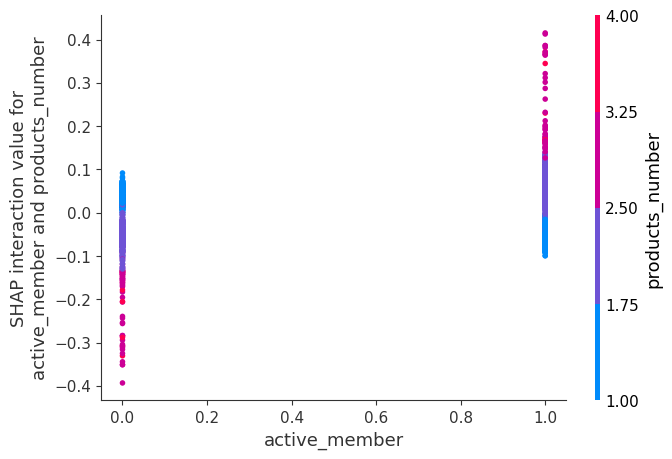

In [41]:
shap.dependence_plot(
    ("active_member", "products_number"),
    shap_interaction_values, X_test_num,
    display_features=X_test_num
)

### decision plot

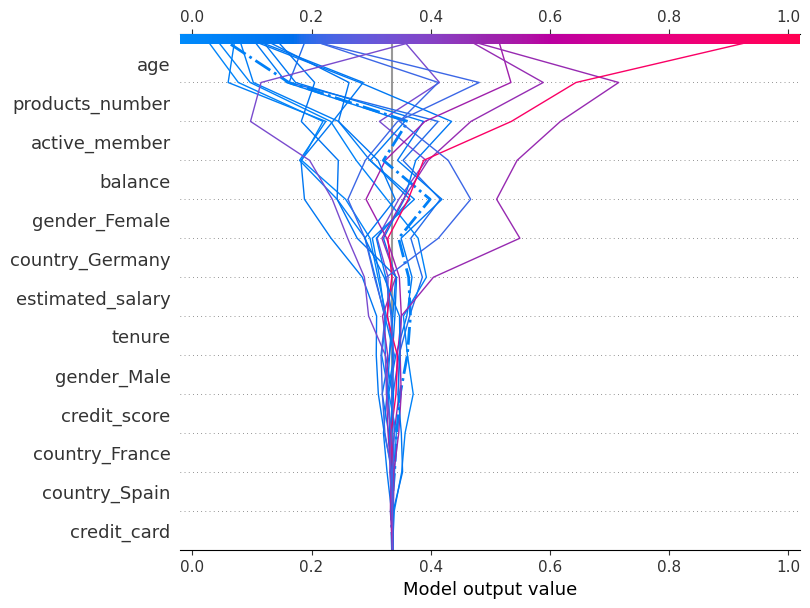

In [17]:
shap.decision_plot(explainer.expected_value, shap_values[:20], X_test_num.columns, link="logit", ignore_warnings=True, highlight=10)

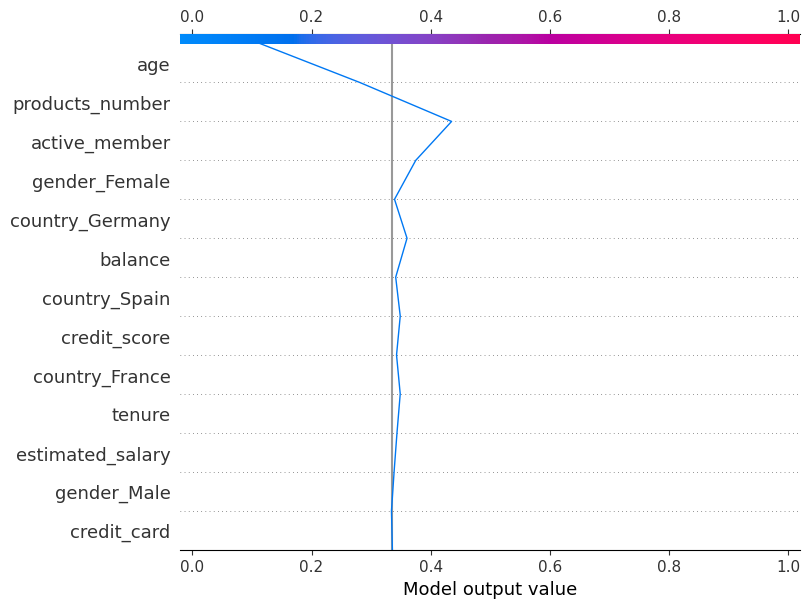

In [18]:
row = 1
shap.decision_plot(explainer.expected_value, shap_values[row], X_test_num.columns, link="logit")

### waterfall plot

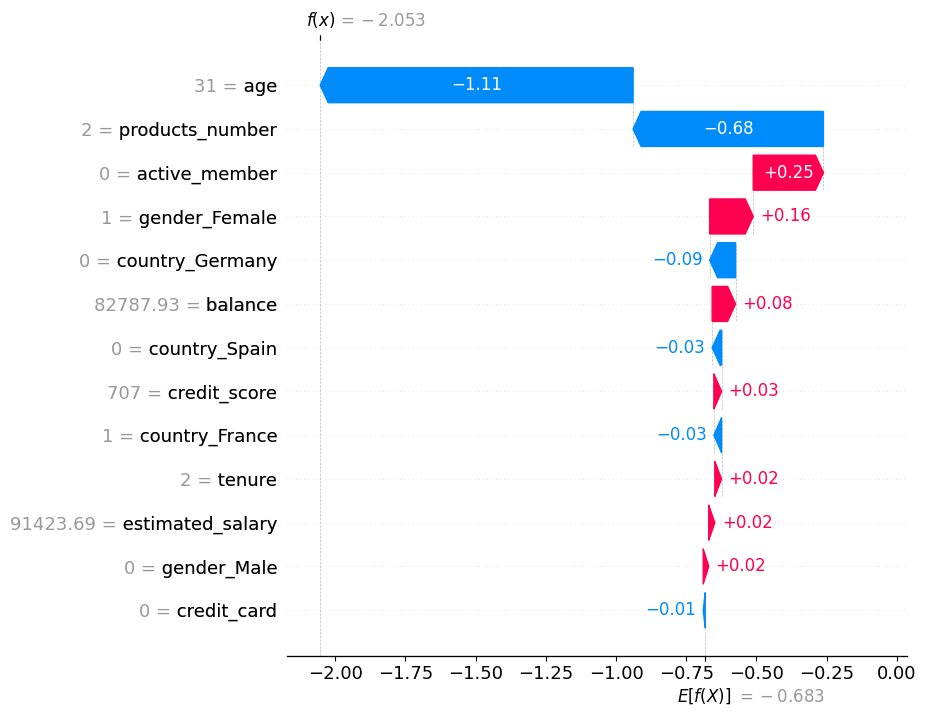

In [19]:
# SHAP waterfall plot - The waterfall plot is another local analysis plot of a single instance prediction.
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[row], 
        base_values=explainer.expected_value, 
        data=X_test_num.iloc[row],  
        feature_names=X_test_num.columns.tolist()
    ),
    max_display=25
)

### force plot

In [21]:
shap.initjs()
# shap_values = explainer.shap_values(X_test_num)

explanation = explainer(X_test_num.sample(330))
shap.plots.force(explanation)

## Examine few examples

In [26]:
# Get predicted probabilities for all examples in the test set
all_predicted_probabilities = clf_xgb.predict_proba(X_test_num)

# Get predicted classes for all examples in the test set
all_predictions = clf_xgb.predict(X_test_num)

y_test_all = pd.DataFrame(y_test).reset_index()
y_test_all['pred'] = all_predictions
y_test_all['proba'] = all_predicted_probabilities[:,1]

correct_1_max = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==1)
]['proba'].idxmax()

correct_1_min = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==1)
]['proba'].idxmin()

correct_0_max = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==0)
]['proba'].idxmax()

correct_0_min = y_test_all[
    (y_test_all['churn']==y_test_all['pred'])
    & (y_test_all['churn']==0)
]['proba'].idxmin()

incorrect_0_max = y_test_all[
    (y_test_all['churn']!=y_test_all['pred'])
    & (y_test_all['churn']==0)
]['proba'].idxmax()

incorrect_1_min = y_test_all[
    (y_test_all['churn']!=y_test_all['pred'])
    & (y_test_all['churn']==1)
]['proba'].idxmin()

selected_examples = [
    correct_1_max,
    correct_1_min,
    incorrect_1_min,
    correct_0_max,
    correct_0_min,
    incorrect_0_max
]

CORRECT PREDICTION
True value 1, predicted probab 0.98


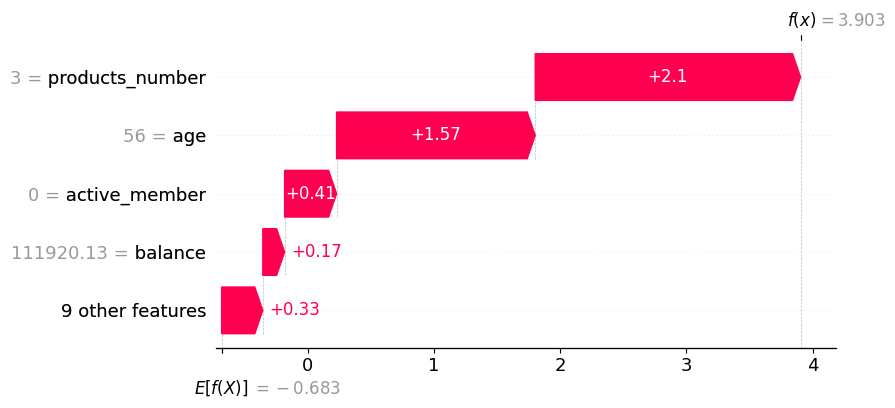

CORRECT PREDICTION
True value 1, predicted probab 0.50


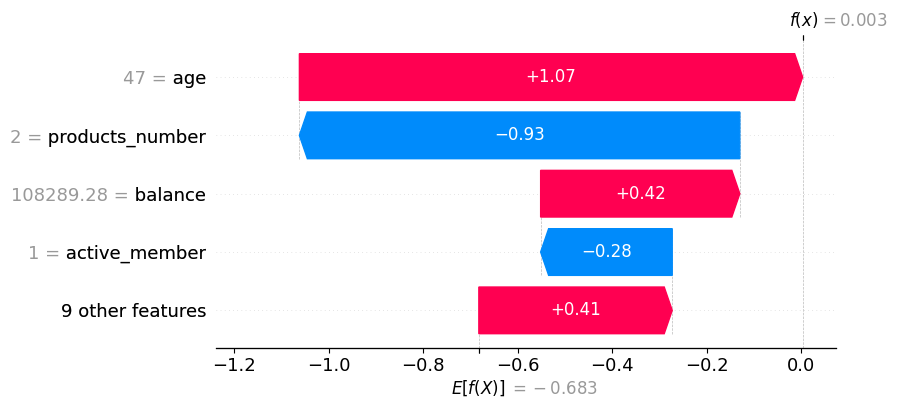

INCORRECT PREDICTION
True value 1, predicted probab 0.03


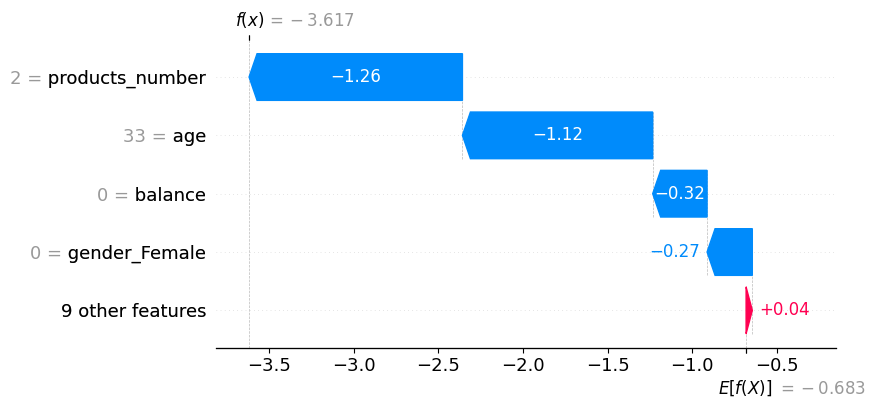

CORRECT PREDICTION
True value 0, predicted probab 0.50


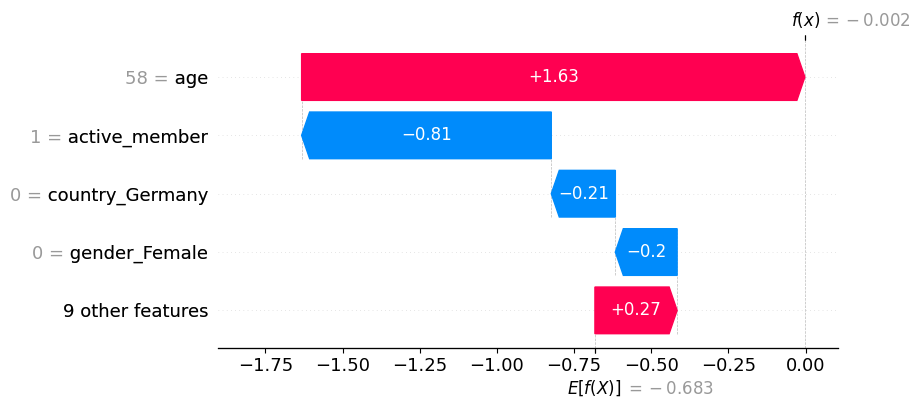

CORRECT PREDICTION
True value 0, predicted probab 0.02


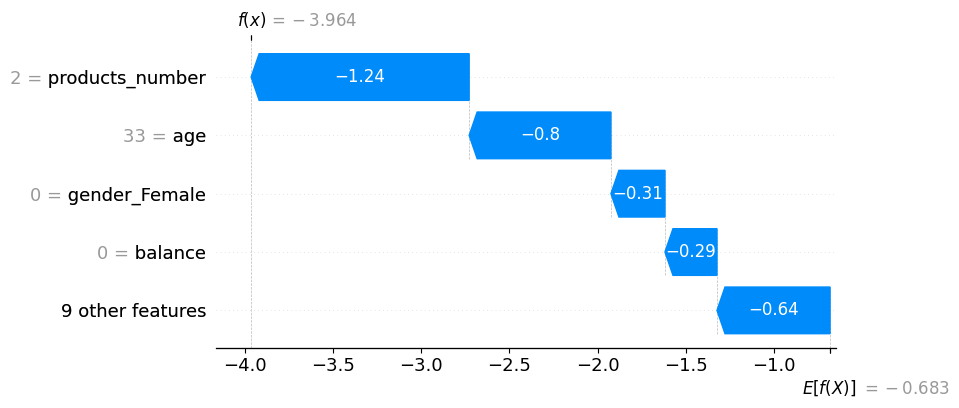

INCORRECT PREDICTION
True value 0, predicted probab 0.96


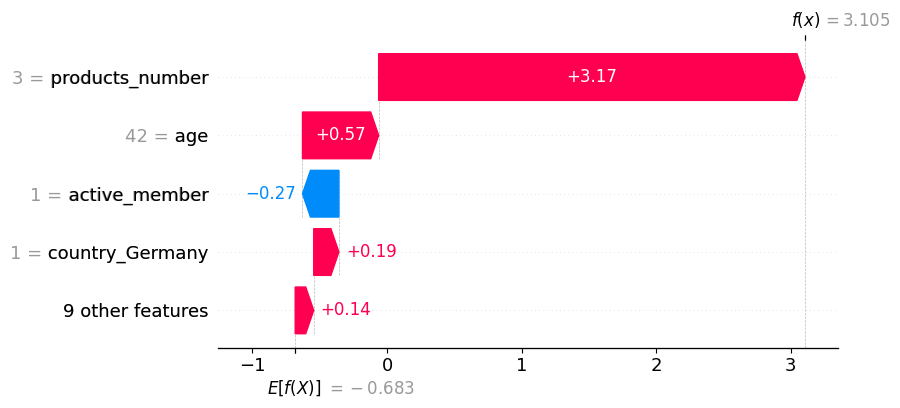

In [27]:
for i in selected_examples:
    if y_test.iloc[i] == all_predictions[i]:
        print('CORRECT PREDICTION')
    else:
        print('INCORRECT PREDICTION')
        
    print(f'True value {y_test.iloc[i]}, predicted probab {all_predicted_probabilities[i,1]:.2f}')
    
#     xi = xi[1]

    # SHAP waterfall plot - The waterfall plot is another local analysis plot of a single instance prediction.
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[i], 
            base_values=explainer.expected_value, 
            data=X_test_num.iloc[i],  
            feature_names=X_test_num.columns.tolist()
        ),
        max_display=5
    )

In [28]:
shap_values.shape

(3300, 13)

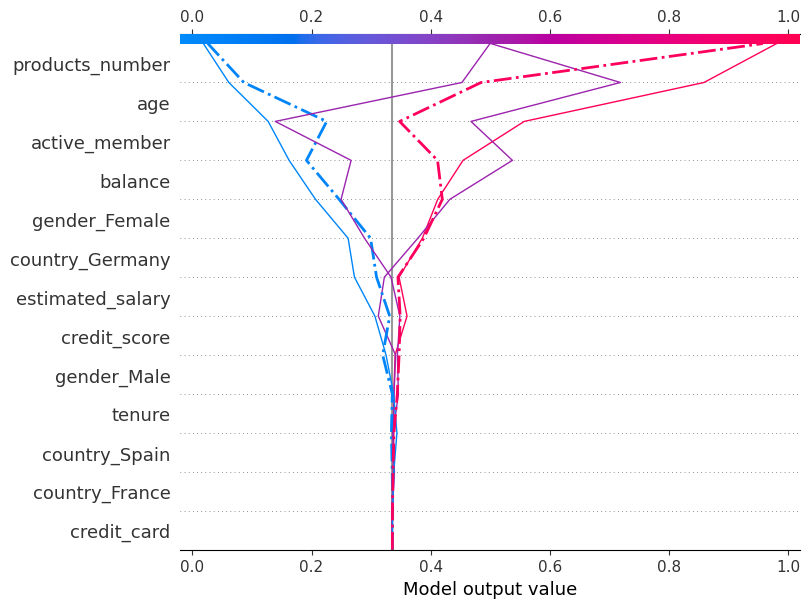

In [29]:
shap.decision_plot(explainer.expected_value, shap_values[selected_examples, :], X_test_num.columns, link="logit", ignore_warnings=True, highlight=[2,5])

In [30]:
shap.initjs()
# shap_values = explainer.shap_values(X_test_num)

explanation = explainer(X_test_num.iloc[selected_examples])
shap.plots.force(explanation)